Einführung in die Monte Carlo-Simulation als Methode zur Modellierung von Finanzinstrumenten.

Erklärung des Ziels: Vorhersage der zukünftigen Preisentwicklung der Apple-Aktien durch Simulation.







In [71]:
#Verwendung von Bibliotheken wie NumPy und pandas in Python.
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline 
import yfinance as yf
from scipy.stats import norm
from scipy.optimize import fsolve

Grundlegende Begriffe:

Definition von Aktienkurs, täglicher Zuwachs und Volatilität.
Erklärung der Annahme eines stetigen Modells für die Preisentwicklung.

In [72]:


# Der Zeitraum den wir für unsere Daten festlegen begrenzt sich vom 01.01.2022 bis zum 21.11.2023
start = '2022-01-01'
end = '2023-11-21'

# für die Apple Aktie
symbol = 'AAPL'

# Die Daten ziehen wir uns mit yfinance runter
apple = yf.download(symbol, start=start, end=end)

# Daten anzeigen
print(apple)


[*********************100%%**********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2022-01-03  177.830002  182.880005  177.710007  182.009995  179.953903   
2022-01-04  182.630005  182.940002  179.119995  179.699997  177.669983   
2022-01-05  179.610001  180.169998  174.639999  174.919998  172.943985   
2022-01-06  172.699997  175.300003  171.639999  172.000000  170.056976   
2022-01-07  172.889999  174.139999  171.029999  172.169998  170.225067   
...                ...         ...         ...         ...         ...   
2023-11-14  187.699997  188.110001  186.300003  187.440002  187.440002   
2023-11-15  187.850006  189.500000  187.779999  188.009995  188.009995   
2023-11-16  189.570007  190.960007  188.649994  189.710007  189.710007   
2023-11-17  190.250000  190.380005  188.570007  189.690002  189.690002   
2023-11-20  189.889999  191.910004  189.880

Kurze Erklärung, was uns der Datensatz zeigt


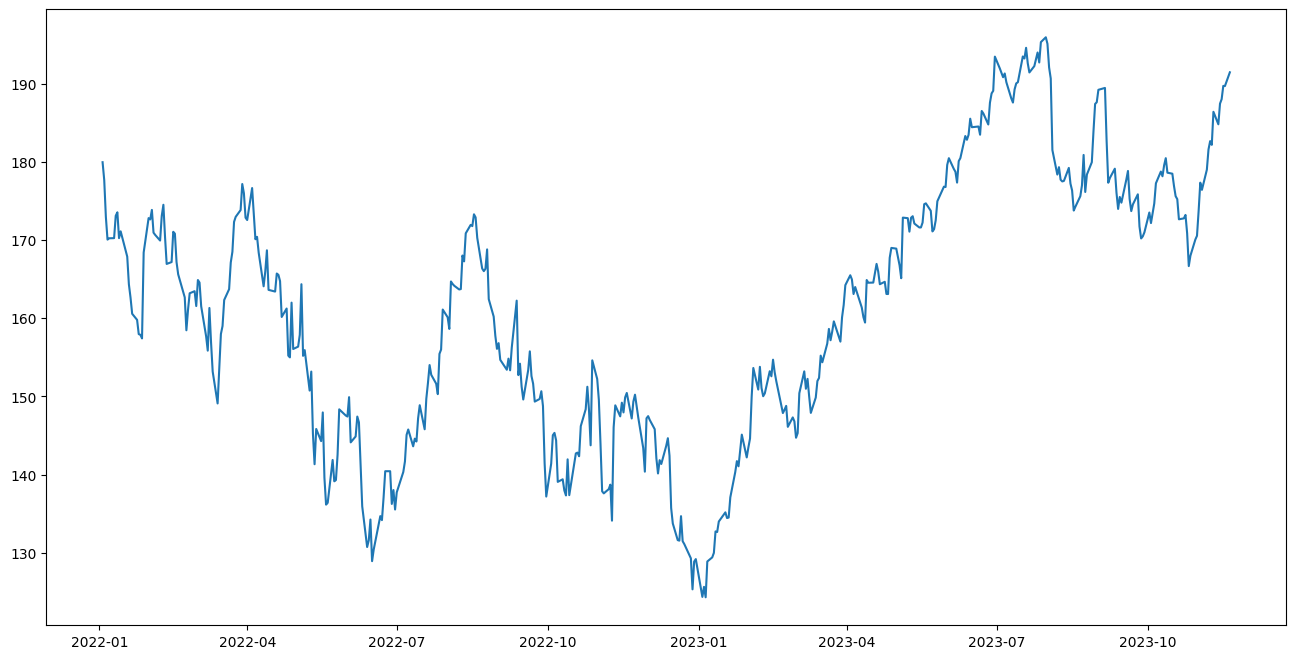

In [73]:
#Wir plotten den Kurvenverlauf unserer Aktie 
plt.figure(figsize=(16, 8))
plt.plot(apple["Adj Close"])

In [74]:
#Den letzten Preis der Aktie speichern wir ein, um später mit ihr weiterzuarbeiten.
last_price = apple["Adj Close"][-1]
print(last_price)

191.4499969482422


/var/folders/2g/2kljx72s71qfpqfsl03p810w0000gn/T/ipykernel_2468/2306033425.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_price = apple["Adj Close"][-1]


In [75]:
#Wir speichern die tägliche Kursveränderung in % (tägliche Rendite) in eine neue Liste ein. Diese wird für unsere Monte Carlo Simulation benötigt
returns = apple["Adj Close"].pct_change()
print(returns)

Date
2022-01-03         NaN
2022-01-04   -0.012692
2022-01-05   -0.026600
2022-01-06   -0.016693
2022-01-07    0.000988
                ...   
2023-11-14    0.014286
2023-11-15    0.003041
2023-11-16    0.009042
2023-11-17   -0.000105
2023-11-20    0.009278
Name: Adj Close, Length: 474, dtype: float64


Einführung der Normalverteilung als Wahrscheinlichkeitsverteilung.
Bedeutung von Mittelwert und Standardabweichung in der Normalverteilung.

In [76]:
#Wir speichern die Volatilität für die Monte Carlo Simulation ein. Dabei verwenden wir die Standartabweichung unserer Rendite.
daily_vol = returns.std()

In [77]:
#Wir führen 1000 Simulationen durch für den Zeitraum vom 22.11.2023 bis 21.12.2023 (30 Tage).
num_sim = 1000
num_days = 30

Für die Berechnung unserer simulierten Werte in den 30 Tagen verwenden wir folgende Formel:
Neuer Aktienkurs = letzter Aktienpreis × [ (1+Zufallszahl) × Volatilitat ]
-> Der neue Aktienkurs ergibt sich aus dem letzten Aktienpreis, multipliziert mit dem Produkt aus unserer Volatilität und 1 + der Zufallszahl.
Die Zufallszahl dabei nimmt einen Wert zwischen 0 und unserer Standartabweichung an. Die Monte Carlo Simulation sorgt dafür, dass verschiedene Szenarien
simuliert werden und wir für die Zufallszahl verschiedene Werte in dem Bereich (zwischen 0 und der Standartabweichung) einsetzen können.
Dies macht den gebrauch der Monte Carlo Simulation wertvoll, da man mit menschenhand die Grosse Anzahl an Möglichkeiten kaum festhalten kann.
Die verschiedenen Szenarien werden in eine Schleife gepackt, bei der wir den Output in eine leere Liste abspeichern. 
Wir gehen in unserer Simulation davon aus, dass unsere Daten normalverteilt ausgewertet werden. Undzwar aus Folgenden Gründen:
- Die Preisentwicklung von unserer Apple Aktie nähert sich der Normalverteilung stark an, da es viele unabhängige Variablen gibt, die auf den Aktienkurs 
  treffen. 
- Das codieren mit der Normalverteilung ist verhältnismässig einfacher im Vergleich zu anderen Verteilungen, da sie zum einen am häufigsten eintrifft 
  und zum anderen mathematisch gut erklärbar ist.
- Obwohl viele Aktien nicht normalverteilt sind, ermöglicht uns die Prognose mittels Monte Carlo und der dazugehörigen Normalverteilung, dennoch eine 
  realitätsnahe und präzise Prognose durchzuführen. Grund dafür ist der zentrale Grenzwertsatz (der Zentrale Grenzwertsatz besagt kurz zusammengefasst, 
  dass unsere Verteilung von unserer Stichprobe, die aus mehr als 30 Werten besteht, aus einer beliebig verteilten Grundgesamtheit einer Normalverteilung
  entspricht.

In [78]:
#Zuerst erstellen wir einen leeren Dataframe
simulation_df = pd.DataFrame()
#Es wird eine leere Liste erstellt 
price_series = []

#Es beginnt mit einer for Schleife, in der noch eine for Schleife steckt:
for i in range(num_sim):
    #Da wir mehrere for Schleifen durchlaufen, müssen wir die Liste leeren
		#Sie wird dann in den df hinzugefügt.
    price_series.clear()
    #Counter brauchen wir für die zweite for Schleife
    counter = 0
    
    #Preisberechnung
    #Es werden werte zwischen 0 und unserer daily_vol genommen.
    price = last_price * (1+ np.random.normal(0, daily_vol)) 
   
    price_series.append(price)
    
    #Die Simulation wird für 30 Tage durchgeführt und hört auf bei unserem Counter.
    for x in range(num_days):
        if counter == 29:
            break 
            
        #Unser Preis wird der Price Series hinzugefügt, damit unsere zufällig gewählten 
	    #Abweichungen addiert werden.    
        price = price_series[counter] * (1+ np.random.normal(0, daily_vol))
        price_series.append(price)
        counter += 1
        
    #Zum Schluss fügen wir unsere price Series in den df ein.    
    simulation_df[i] = price_series

/var/folders/2g/2kljx72s71qfpqfsl03p810w0000gn/T/ipykernel_2468/2207500385.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  simulation_df[i] = price_series


Wir erhalten nun ein Diagramm, welches unsere Simulierten Aktienpreise beinhaltet. Für uns ist jedoch nur der letzte Wert relevant, da wir den Preis für
den Tag x=30 herausfinden wollen.

In [79]:
simulation_df

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,193.901931,190.399225,194.038381,188.546825,192.957844,190.033979,195.750559,190.241871,184.490223,199.187884,...,196.726283,187.399832,198.412439,190.802810,192.882966,185.717711,187.412418,190.301073,189.527811,196.656935
1,188.165069,195.473417,191.524431,187.005799,196.657936,191.407892,198.381390,191.198349,186.148786,198.294739,...,189.888382,187.799030,197.251451,196.949954,185.785803,182.515306,186.194437,183.601774,191.738998,198.628287
2,188.077828,190.241042,192.888982,182.024604,199.481334,193.236513,200.430502,190.477295,184.397223,206.877331,...,193.843774,180.516174,189.665065,201.386068,188.332908,176.959484,187.170032,181.972852,194.999069,195.860271
3,191.229967,189.957230,193.096967,178.091843,193.074149,194.717803,193.839988,188.622342,184.384626,209.266015,...,198.115787,182.079200,191.990737,209.656860,186.719553,175.973923,185.165000,186.038898,193.128296,186.057067
4,188.895510,190.485598,195.707336,174.408164,200.038358,188.984214,188.522413,195.783948,188.139054,208.938775,...,201.130414,178.962218,195.334874,212.972198,184.061984,175.056864,182.956764,184.857365,188.824299,183.476712
5,190.305954,189.103293,196.316477,172.304197,198.843608,183.460058,181.461608,192.066880,187.283759,205.051724,...,193.488901,170.836772,194.880110,213.340989,182.896347,175.407788,182.546064,183.707745,186.937734,183.200857
6,191.821906,187.288281,197.353875,179.559107,198.452190,185.170180,180.818164,188.702258,183.438048,213.028564,...,189.382522,167.462368,190.996102,212.058881,176.571103,174.903174,181.770569,183.745786,187.058082,186.448012
7,191.210349,189.166117,197.020435,183.888689,200.327550,187.144824,184.417325,189.550726,180.326123,215.991576,...,193.639289,166.102612,190.457296,207.401118,172.845193,173.302566,178.118453,180.488073,182.124712,181.858294
8,191.291869,192.471908,198.176332,185.503471,194.482771,190.215575,180.642663,187.358856,179.437409,214.145601,...,189.929607,164.399141,199.885659,213.407149,175.845297,171.789674,183.463544,176.866502,183.769792,183.581526
9,192.043252,189.339739,204.116447,179.459228,194.238448,194.191853,178.643552,191.551328,180.441482,210.263609,...,199.427168,162.280419,201.994655,209.191095,173.687124,171.665365,186.117189,176.709868,179.766621,179.562453



Trendmuster erkennen ? Adrian brauchen wir das ? Was meinst du?

Die einzelnen Simulationen zeigen wir nun in einem Plot. Jeder einzelne Kurvenverlauf repräsentiert hierbei eine Simulation von 30 Tagen.
Im Gesammten haben wir also 1000 verschiedene Kurvenverläufe mit dem Aktienpreis von jeweils 30 Tagen.

/var/folders/2g/2kljx72s71qfpqfsl03p810w0000gn/T/ipykernel_2468/4115602762.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.axhline(apple["Adj Close"][-1], color = "r")


<function matplotlib.pyplot.show(close=None, block=None)>

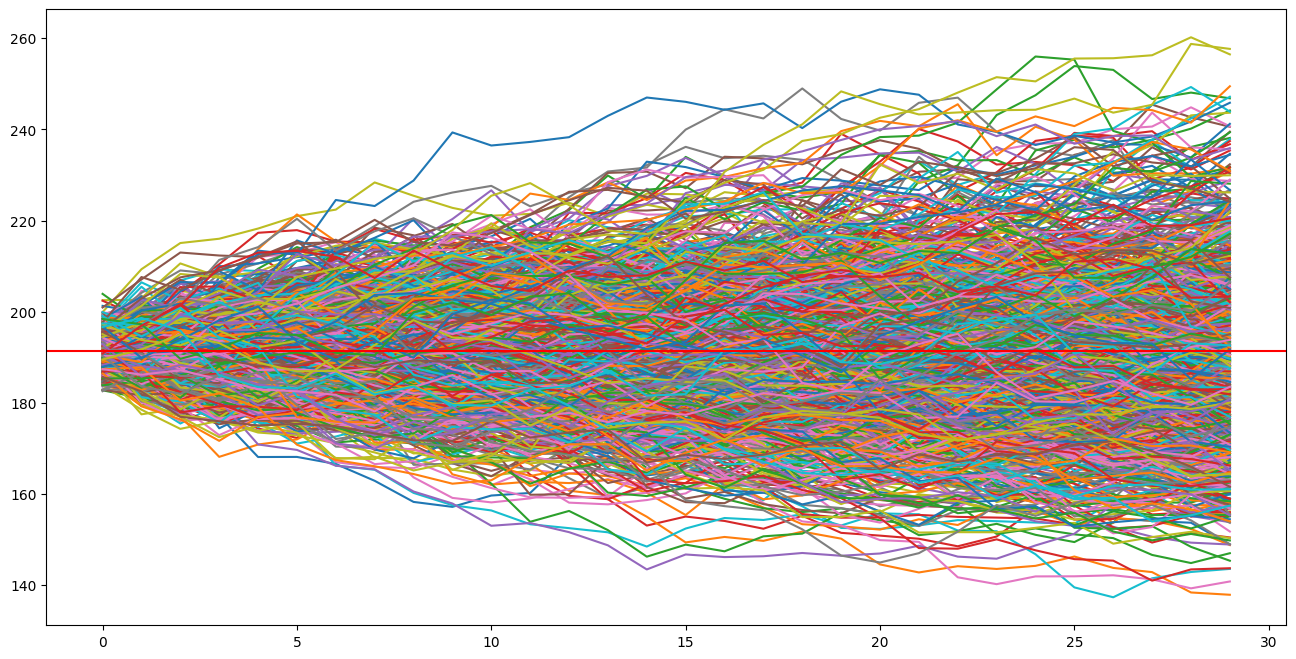

In [80]:
plt.figure(figsize=(16, 8))
plt.plot(simulation_df)
plt.axhline(apple["Adj Close"][-1], color = "r")
plt.show

Diskussion möglicher Unsicherheiten in der Simulation. Adrian ? Was denkst du? Brauchen wir das haahahaha

Wir betrachten nun unser Ergebnis der Simulation genauer. Und was uns dabei auffällt.

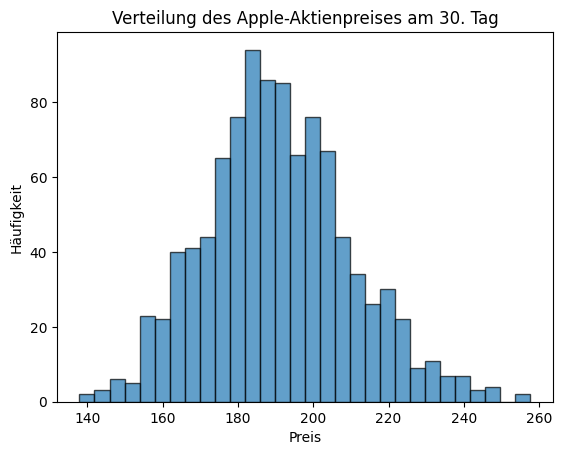

In [81]:
#Letzten Tag der Simulation abspeichern 
last_day_results   = simulation_df.iloc[-1, :]

# Histogramm erstellen für unser last_day_results
plt.hist(last_day_results, bins=30, edgecolor='black', alpha=0.7)
plt.title('Verteilung des Apple-Aktienpreises am 30. Tag')
plt.xlabel('Preis')
plt.ylabel('Häufigkeit')
plt.show()

Erklärung des Boxplots als grafische Darstellung von Quartilen, Median und Ausreißern.

Diskussion möglicher Abweichungen zwischen simulierten und historischen Daten.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


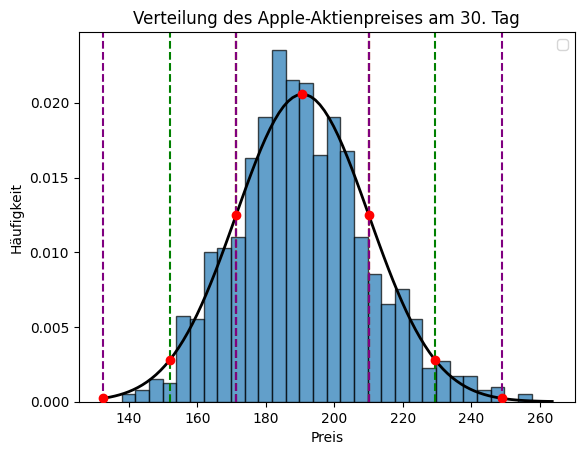

In [82]:

#Wir erstellen erneut das selbe histogramm von oben
plt.hist(last_day_results, bins=30, density=True, edgecolor='black', alpha=0.7)

# Wir berechnen unser mu und sigma für das Erstellen einer Normalverteilug
mu, sigma = np.mean(last_day_results), np.std(last_day_results)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, sigma)

# Wir plotten unsere Normalverteilungsfunktion
plt.plot(x, p, 'k', linewidth=2)

plt.title('Verteilung des Apple-Aktienpreises am 30. Tag')
plt.xlabel('Preis')
plt.ylabel('Häufigkeit')

# Finden der Stelle für das Maximum
max_point = x[np.argmax(p)]

# Zeichnet roten Punkt am Maximum
plt.scatter(max_point, norm.pdf(max_point, mu, sigma), color='red', zorder=5)



# Berechne Schnittpunkte unserer empirischen Regel also von mu +- sigma und der Funktion der Normalverteilung
def find_intersection(x):
    return norm.pdf(x, mu, sigma) - norm.pdf(mu - sigma, mu, sigma)

intersection_left = fsolve(find_intersection, mu - sigma)[0]
intersection_right = fsolve(find_intersection, mu + sigma)[0]

# Zeichnet eine rote senkrechte Linie links vom Mittelwert bis zum Schnittpunkt ein.
plt.axvline(mu - sigma, color='red', linestyle='--')
plt.axvline(intersection_left, color='red', linestyle='--')

# Zeichnet eine rote senkrechte Linie rechts vom Mittelwert bis zum Schnittpunkt ein.
plt.axvline(mu + sigma, color='red', linestyle='--')
plt.axvline(intersection_right, color='red', linestyle='--')

# Zeichnet roten Punkt an den Schnittpunkten ein.
plt.scatter([intersection_left, intersection_right], [norm.pdf(intersection_left, mu, sigma), norm.pdf(intersection_right, mu, sigma)], color='red', zorder=5)


# Der selbe Prozess nur diesmal für den Abstand von mu zu +- 2 mal dem sigma
def find_intersection(x):
    return norm.pdf(x, mu, sigma) - norm.pdf(mu - 2 * sigma, mu, sigma)

intersection_left = fsolve(find_intersection, mu - 2* sigma)[0]
intersection_right = fsolve(find_intersection, mu + 2* sigma)[0]

plt.axvline(mu - sigma, color='green', linestyle='--')
plt.axvline(intersection_left, color='green', linestyle='--')

plt.axvline(mu + sigma, color='green', linestyle='--')
plt.axvline(intersection_right, color='green', linestyle='--')

plt.scatter([intersection_left, intersection_right], [norm.pdf(intersection_left, mu, sigma), norm.pdf(intersection_right, mu, sigma)], color='red', zorder=5)


# und ein drittes und letztes mal für mu +- 3 mal sigma
def find_intersection(x):
    return norm.pdf(x, mu, sigma) - norm.pdf(mu - 3*sigma, mu, sigma)

intersection_left = fsolve(find_intersection, mu - 3*sigma)[0]
intersection_right = fsolve(find_intersection, mu + 3*sigma)[0]

plt.axvline(mu - sigma, color='purple', linestyle='--')
plt.axvline(intersection_left, color='purple', linestyle='--')

plt.axvline(mu + sigma, color='purple', linestyle='--')
plt.axvline(intersection_right, color='purple', linestyle='--')

plt.scatter([intersection_left, intersection_right], [norm.pdf(intersection_left, mu, sigma), norm.pdf(intersection_right, mu, sigma)], color='red', zorder=5)

plt.legend()
plt.show()


Was im oberen Plot zu erkennen ist, ist die skizzierte Normalverteilung von unserem Histogramm (Dem Endresultat von der 30 tägigen Simulation.
Wir können folgende Punkte erkennen, die eine Normalverteilung beweisen:
1. Man sieht eine klare Glockenform, mit dem Mittelwert als Höhepunkt.
2. Der Median und der Mittelwert sind identisch (siehe Code unter diesem Text)
3. Wir erfüllen die Empirische Regel, auch genannt die 68-95-99.5 Regel -> Die Werte zwischen mu - sigma und mu + sigma entsprechen 68% aller Werte aus unserem Ergebnis (gestrichelte Linien im Inneren) ->  Die Werte zwischen mu - 2*sigma und mu + 2*sigma entsprechen 95% aller Werte aus unserem Ergebnis (grüne gestrichelte Linien -> und die Werte zwischen mu - 3*sigma und mu + 3*sigma entsprechen 99.5% aller Werte aus unserem Ergebnis (äusserste gestrichelten Linien)
4. Wir können eine symmetrie erkennen und besitzen sowohl einen Erwartungswert, als auch eine Standartabweichung
5. unser Maximum liegt bei mu
6. die Kurve ist stetig von minus unendlich bis plus unendlich 
7. wir besitzen zwei wendestellen bei y = mu - sigma und  y = mu + sigma

In [83]:
print("Mittelwert: " + str(last_day_results.mean()))
print("Median: " + str(last_day_results.median()))
print("Standartabweichung: " + str(last_day_results.std()))


Mittelwert: 190.68060794578474
Median: 189.52268826961972
Standartabweichung: 19.403942761421867


Wir haben zusätlich auch ein Boxplot erstellt, um die 5 grössten Merkmale anschaulicher darzustellen. Median, Maximum und Minimum und das 1. und 3. Quartil.
Zusätzlich haben wir dann noch den Wert vom oberen und unteren Whisker angegeben, um zu sehen, welchen Wert sogenannte "Ausreisser" haben müssen, um ausserhalb von unserem Boxplot zu liegen.

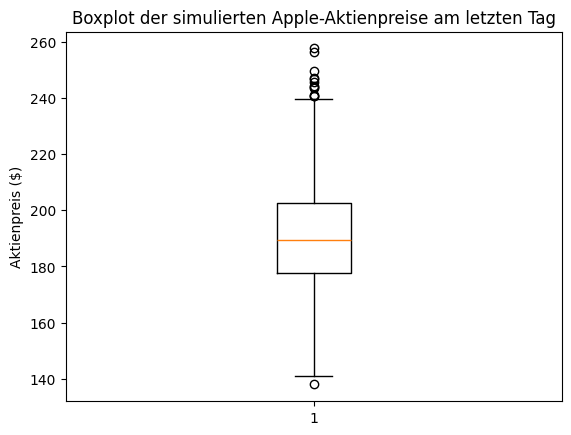

In [84]:
# Boxplot erstellen
plt.boxplot(last_day_results)
plt.title('Boxplot der simulierten Apple-Aktienpreise am letzten Tag')
plt.ylabel('Aktienpreis ($)')
plt.show()

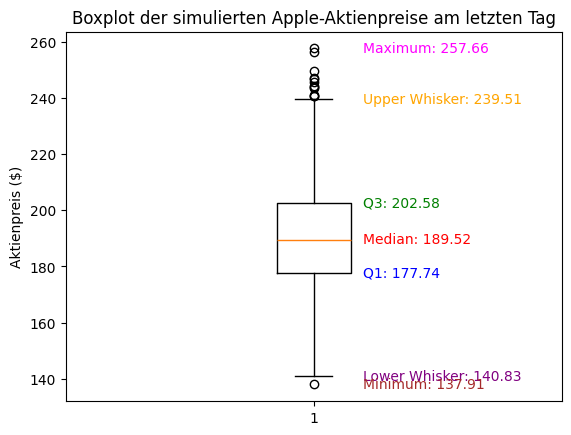

In [85]:

# Boxplot erstellen und Whiskers mit 1,5-fachem Interquartilabstand setzen
boxplot = plt.boxplot(last_day_results, whis=1.5)

# Quartile 
q1_value = round(np.percentile(last_day_results, 25), 2)
q3_value = round(np.percentile(last_day_results, 75), 2)

# Median
median_value = round(np.median(last_day_results), 2)

# Whisker
lower_whisker = round(boxplot['whiskers'][0].get_ydata()[1], 2)
upper_whisker = round(boxplot['whiskers'][1].get_ydata()[1], 2)

# Minimum und Maximum
min_value = round(np.min(last_day_results), 2)
max_value = round(np.max(last_day_results), 2)

# Text für den Median hinzufügen
plt.text(1.10, median_value, f'Median: {median_value}', color='red', fontsize=10, verticalalignment='center')

# Text für das 1. Quartil hinzufügen
plt.text(1.10, q1_value, f'Q1: {q1_value}', color='blue', fontsize=10, verticalalignment='center')

# Text für das 3. Quartil hinzufügen
plt.text(1.10, q3_value, f'Q3: {q3_value}', color='green', fontsize=10, verticalalignment='center')

# Text für den lower Whisker hinzufügen
plt.text(1.10, lower_whisker, f'Lower Whisker: {lower_whisker}', color='purple', fontsize=10, verticalalignment='center')

# Text für den upper Whisker hinzufügen
plt.text(1.10, upper_whisker, f'Upper Whisker: {upper_whisker}', color='orange', fontsize=10, verticalalignment='center')


# Text für den Minimum hinzufügen
plt.text(1.10, min_value, f'Minimum: {min_value}', color='brown', fontsize=10, verticalalignment='center')

# Text für den Maximum hinzufügen
plt.text(1.10, max_value, f'Maximum: {max_value}', color='magenta', fontsize=10, verticalalignment='center')


# Diagrammsbeschriftung
plt.title('Boxplot der simulierten Apple-Aktienpreise am letzten Tag')
plt.ylabel('Aktienpreis ($)')

# Diagramm anzeigen
plt.show()


Mach ich dann noch mit der Verteilungsfunktion zusammen(ilyas aufgabe)
Zusammenfassung der Ergebnisse und Schlussfolgerungen.
Reflexion über die Anwendbarkeit der Monte Carlo-Simulation auf die Vorhersage von Aktienkursen.


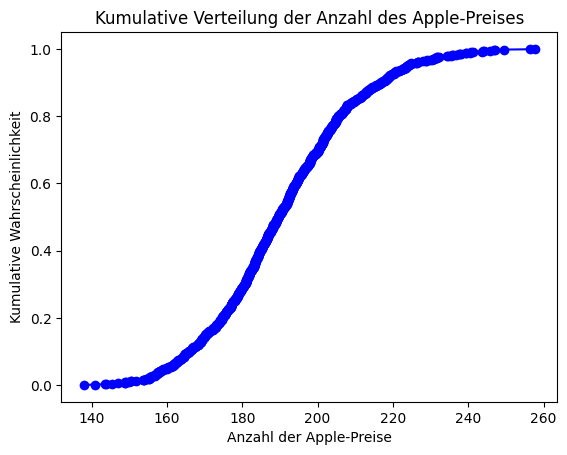

In [86]:
sorted_data = np.sort(last_day_results)
cumulative_prob = np.arange(1, len(sorted_data) + 1) / len(sorted_data)

plt.plot(sorted_data, cumulative_prob, marker='o', linestyle='-', color='b')
#plt.hist(last_day_results, bins=30, density=True, cumulative=True, alpha=0.7, color='b', edgecolor='k')
plt.xlabel('Anzahl der Apple-Preise')
plt.ylabel('Kumulative Wahrscheinlichkeit')
plt.title('Kumulative Verteilung der Anzahl des Apple-Preises')
plt.show()

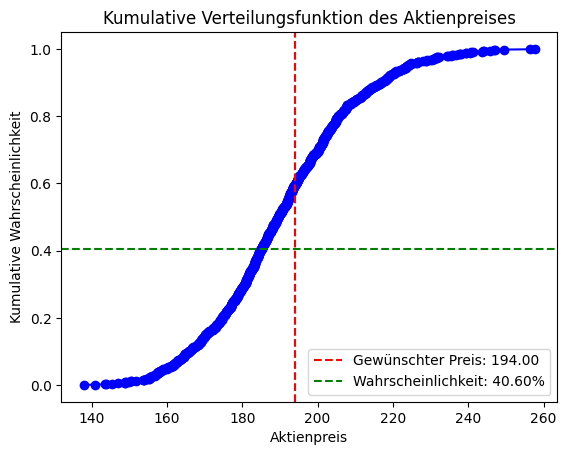

Die Wahrscheinlichkeit, dass der Aktienpreis mindestens 194.00 erreicht, beträgt 40.60%


In [87]:

# Definiere den gewünschten Preis x (wert nach unserer frage anpassen)
x_value =  194.00

# Finde den Index des ersten Elements in der sortierten Datenliste, das größer oder gleich x ist
index_x = np.searchsorted(sorted_data, x_value, side='right')

# Berechne die kumulierte Wahrscheinlichkeit, dass der Preis mindestens x ist
probability_x = 1 - cumulative_prob[index_x - 1] if index_x > 0 else 0

# Plot der kumulativen Verteilungsfunktion
plt.plot(sorted_data, cumulative_prob, marker='o', linestyle='-', color='b')
plt.xlabel('Aktienpreis')
plt.ylabel('Kumulative Wahrscheinlichkeit')
plt.title('Kumulative Verteilungsfunktion des Aktienpreises')

# Markiere den gewünschten Preis auf der X-Achse
plt.axvline(x=x_value, color='r', linestyle='--', label=f'Gewünschter Preis: {x_value:.2f}')

# Markiere die kumulierte Wahrscheinlichkeit auf der Y-Achse
plt.axhline(y=probability_x, color='g', linestyle='--', label=f'Wahrscheinlichkeit: {probability_x:.2%}')

# Anzeigen des Plots
plt.legend()
plt.show()

# Ausgabe der berechneten Wahrscheinlichkeit
print(f'Die Wahrscheinlichkeit, dass der Aktienpreis mindestens {x_value:.2f} erreicht, beträgt {probability_x:.2%}')


Test123